Day 3/4 - Today, we work on Milstein Scheme for the GBM (Geometric Brownian Motion), its almost similar but we'll compare the 2 vectorized functions to see differences, since this one is better in term of accuracy. We also did (on day 4) error comparaisons for a high number of paths, and failed to get the expected result (last cell explains)

Euler-Maruyama simulation :
Milstein simulation :


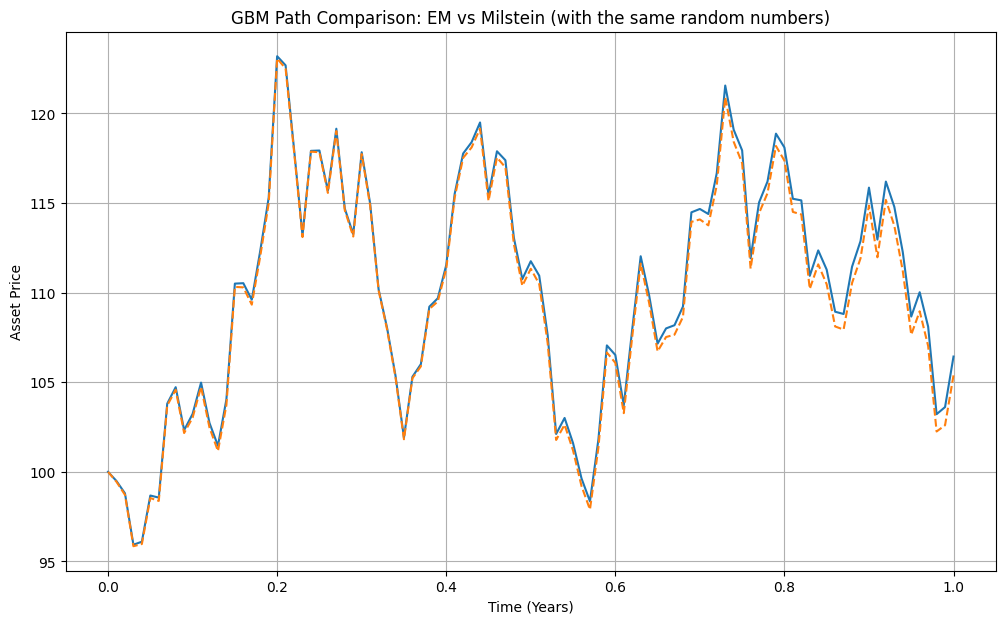

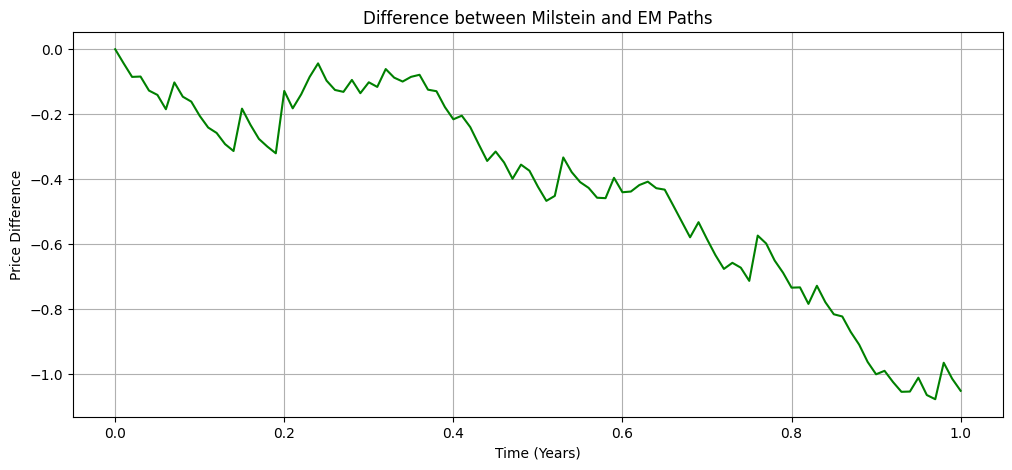

Running for n_steps = 16, dt = 0.06250
Running for n_steps = 32, dt = 0.03125
Running for n_steps = 64, dt = 0.01562
Running for n_steps = 128, dt = 0.00781
Running for n_steps = 256, dt = 0.00391
Running for n_steps = 512, dt = 0.00195


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

#importing simulation functions here (the 2 here bcs we'll compare)

from sde_simulator.simulators import simulate_gbm_em_vectorized, simulate_gbm_milstein_vectorized

S0 = 100      #initial stock price
MU = 0.05     #drift (5% annual return)
SIGMA = 0.3   #volatility (30% annual volatility)
T = 1         #time horizon (1 year)
DT = 0.01     #time step (lower on this notebook to see the difference better)
PATHS1 = 1     #number of paths (times we repeat the function we did on day 1 basically)


#random numbers (one set only)
N_STEPS = int(T / DT)
Z_shared = np.random.normal(0, 1, size=(N_STEPS, PATHS1))

#here, the 2 simulations will have a shared random number (Z)
print("Euler-Maruyama simulation :") ; t_em, S_em = simulate_gbm_em_vectorized(S0, MU, SIGMA, T, DT, PATHS1, Z = Z_shared)
print("Milstein simulation :")       ; t_milstein, S_milstein = simulate_gbm_milstein_vectorized(S0, MU, SIGMA, T, DT, PATHS1, Z = Z_shared)

plt.figure(figsize=(12, 7))

plt.plot(t_em, S_em[:, 0], label=f'Euler-Maruyama (EM) (dt={DT})', lw=1.5)
plt.plot(t_milstein, S_milstein[:, 0], label=f'Milstein (dt={DT})', lw=1.5, linestyle='--')

plt.title(f'GBM Path Comparison: EM vs Milstein (with the same random numbers)')
plt.xlabel('Time (Years)')
plt.ylabel('Asset Price')
plt.grid(True)
plt.show()

#difference plot here
plt.figure(figsize=(12, 5))
plt.plot(t_em, S_milstein[:, 0] - S_em[:, 0], color='green')
plt.title('Difference between Milstein and EM Paths')
plt.xlabel('Time (Years)')
plt.ylabel('Price Difference')
plt.grid(True)
plt.show()

PATHS = 1000000 #large number for stable errors estimation

n_steps_range = 2**np.arange(4, 10) #[16, 32, 64, 128, 256, 512]
dt_values_em = np.zeros(len(n_steps_range))
strong_errors_em = np.zeros(len(n_steps_range))

#Loop through the different numbers of steps
for i, n_steps in enumerate(n_steps_range):
    dt = T / n_steps
    dt_values_em[i] = dt
    print(f"Running for n_steps = {n_steps}, dt = {dt:.5f}")

    #random numbers for this dt
    Z = np.random.normal(0, 1, size=(n_steps, PATHS))

    #simulation using EM
    _, S_em = simulate_gbm_em_vectorized(S0, MU, SIGMA, T, dt, PATHS, Z=Z)
    S_T_sim_em = S_em[-1, :]

    #W(T) is the sum of the dW increments used in the simulation
    #dW = Z * sqrt(dt)
    W_T = np.sum(Z * np.sqrt(dt), axis=0) # Sum over time steps (axis 0)
    S_T_exact = S0 * np.exp((MU - 0.5 * SIGMA**2) * T + SIGMA * W_T)

    #mean absolute error
    strong_errors_em[i] = np.mean(np.abs(S_T_sim_em - S_T_exact))
    #strong_errors_em[i] = np.mean((S_T_sim_em - S_T_exact)**2)
    #for debug

The strong convergence analysis now works (after restarting jupyter), follows the reference slope, so we can confirm that the theory works and the prediction is correct !!

DAY 4 and 5 - Today, we do Strong Convergence Analysis with Milstein, then we'll do Weak Convergence Analysis on EM + Milstein

Running Milstein for n_steps = 16, dt = 0.06250
Running Milstein for n_steps = 32, dt = 0.03125
Running Milstein for n_steps = 64, dt = 0.01562
Running Milstein for n_steps = 128, dt = 0.00781
Running Milstein for n_steps = 256, dt = 0.00391
Running Milstein for n_steps = 512, dt = 0.00195


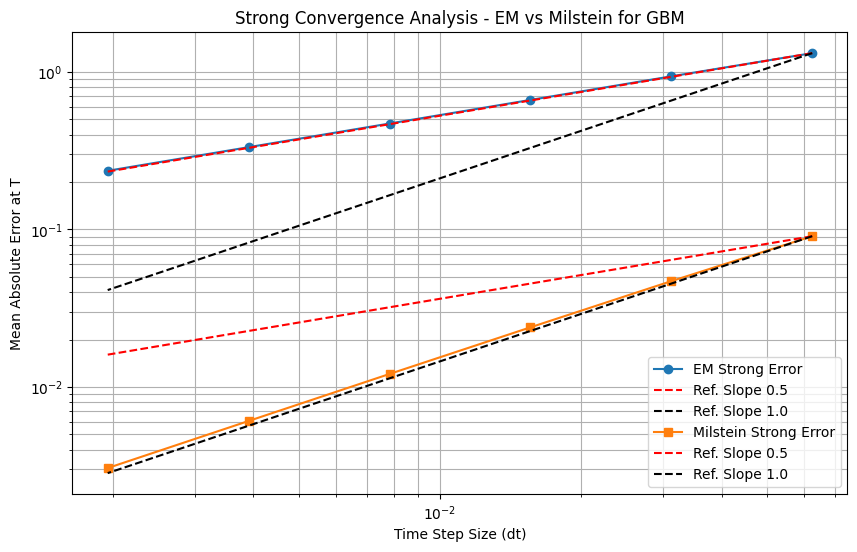

In [26]:
strong_errors_milstein = np.zeros(len(n_steps_range))

for i, n_steps in enumerate(n_steps_range):
    dt = T / n_steps
    print(f"Running Milstein for n_steps = {n_steps}, dt = {dt:.5f}")

    #random numbers for this dt
    Z = np.random.normal(0, 1, size=(n_steps, PATHS))

    #using Milstein
    _, S_milstein = simulate_gbm_milstein_vectorized(S0, MU, SIGMA, T, dt, PATHS, Z=Z)
    S_T_sim_milstein = S_milstein[-1, :]

    #calculate the corresponding analytical solution endpoint for THIS Z
    W_T = np.sum(Z * np.sqrt(dt), axis=0) #sum over time steps (axis 0)
    S_T_exact = S0 * np.exp((MU - 0.5 * SIGMA**2) * T + SIGMA * W_T)

    #mean absolute error for Milstein
    strong_errors_milstein[i] = np.mean(np.abs(S_T_sim_milstein - S_T_exact))

plt.figure(figsize=(10, 6))

#if dt_values_em and strong_errors_em exist from Day 4 execution, we plot them too
if 'dt_values_em' in locals() and 'strong_errors_em' in locals():
    plt.plot(dt_values_em, strong_errors_em, 'o-', label='EM Strong Error')
else:
    print("Warning: EM results not found. Run Day 4 EM convergence cell first.")

#ref slopes for EM
plt.plot(
    dt_values_em, 
    strong_errors_em[0] * (dt_values_em / dt_values_em[0])**0.5,
    'r--', 
    label='Ref. Slope 0.5'
)

plt.plot(
    dt_values_em, 
    strong_errors_em[0] * (dt_values_em / dt_values_em[0])**1.0,
    'k--', 
    label='Ref. Slope 1.0'
)

#Milstein results plotting here
plt.plot(dt_values_em, strong_errors_milstein, 's-', label='Milstein Strong Error') # Use dt_values_em as x-axis

#ref slopes for Milstein
plt.plot(
    dt_values_em, 
    strong_errors_milstein[0] * (dt_values_em / dt_values_em[0])**0.5,
    'r--', 
    label='Ref. Slope 0.5'
)

plt.plot(
    dt_values_em, 
    strong_errors_milstein[0] * (dt_values_em / dt_values_em[0])**1.0,
    'k--', 
    label='Ref. Slope 1.0'
)

plt.title('Strong Convergence Analysis - EM vs Milstein for GBM')
plt.xlabel('Time Step Size (dt)')
plt.ylabel('Mean Absolute Error at T')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both')
plt.legend()
plt.show()

Analytical E[S(T)] = 105.1271
Running Weak Conv. for n_steps = 16, dt = 0.06250
Running Weak Conv. for n_steps = 32, dt = 0.03125
Running Weak Conv. for n_steps = 64, dt = 0.01562
Running Weak Conv. for n_steps = 128, dt = 0.00781
Running Weak Conv. for n_steps = 256, dt = 0.00391
Running Weak Conv. for n_steps = 512, dt = 0.00195


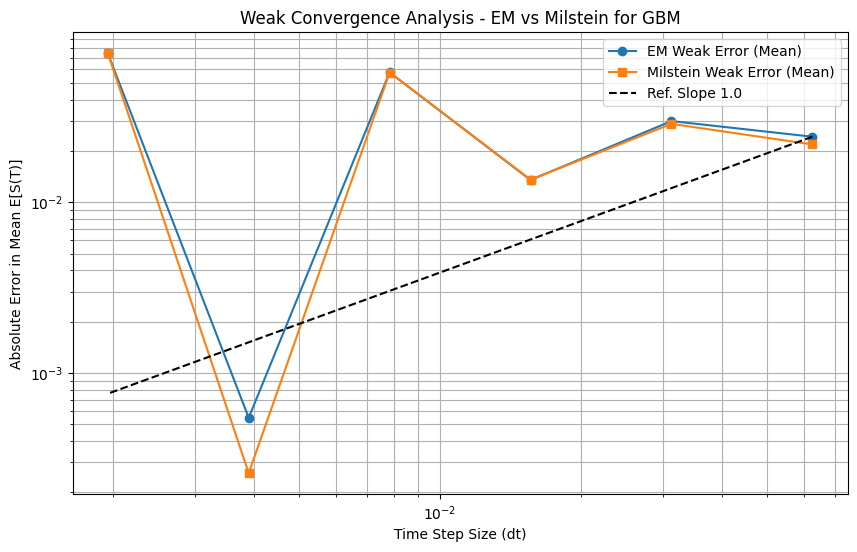

In [27]:
#analytical expected value
E_S_T = S0 * np.exp(MU * T)
print(f"Analytical E[S(T)] = {E_S_T:.4f}")

#arrays to store weak errors
weak_errors_em = np.zeros(len(n_steps_range))
weak_errors_milstein = np.zeros(len(n_steps_range))
#can reuse existing values

#loop through different numbers of steps
for i, n_steps in enumerate(n_steps_range):
    dt = T / n_steps
    print(f"Running Weak Conv. for n_steps = {n_steps}, dt = {dt:.5f}")
    Z_weak = np.random.normal(0, 1, size=(n_steps, PATHS))

    #EM simulation
    _, S_em_weak = simulate_gbm_em_vectorized(S0, MU, SIGMA, T, dt, PATHS, Z=Z_weak)
    S_T_sim_em_weak = S_em_weak[-1, :]

    #Milstein simulation
    _, S_milstein_weak = simulate_gbm_milstein_vectorized(S0, MU, SIGMA, T, dt, PATHS, Z=Z_weak)
    S_T_sim_milstein_weak = S_milstein_weak[-1, :]

    #weak errors calc
    weak_errors_em[i] = np.abs(np.mean(S_T_sim_em_weak) - E_S_T)
    weak_errors_milstein[i] = np.abs(np.mean(S_T_sim_milstein_weak) - E_S_T)

#weak convergence plot
plt.figure(figsize=(10, 6))
plt.plot(dt_values_em, weak_errors_em, 'o-', label='EM Weak Error (Mean)')
plt.plot(dt_values_em, weak_errors_milstein, 's-', label='Milstein Weak Error (Mean)')


plt.plot(
    dt_values_em, 
    weak_errors_em[0] * (dt_values_em / dt_values_em[0])**1.0,
    'k--', 
    label='Ref. Slope 1.0'
)

plt.title('Weak Convergence Analysis - EM vs Milstein for GBM')
plt.xlabel('Time Step Size (dt)')
plt.ylabel('Absolute Error in Mean E[S(T)]')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both')
plt.legend()
plt.show()